# Welcome to Week 3, Part 1: K-Means Clustering
<hr/>

You have a large set of numeric, continuous data, with a variety of features, but no labels. You'd like to see if you can find interesting patterns in this data, but you're not sure where to start.

Enter K-Means clustering.

### Well, wait; What's clustering?

"Clustering" is finding groups of points in your data that share similar features. For example, if you were trying to divide up a city into neighborhoods, you would cluster similar houses together.

### What's "K-Means?"

Continuing the example of neighborhoods: We don't necessarily know how many neighborhoods are in our city before we try to cluster them. There could be 3, 5, 10, or 50. That's where "K" comes in - K is the number of clusters you're identifying. "Means" is simply the idea that for all K clusters, you're taking their average - their mean!

K-Means is a clustering algorithm for "unsupervised learning" - when you don't have labels for your data. If we had data for every house in a city, but no labels for neighborhoods, we would want to use K-Means.

### How do I choose K?

This is a question for which there are many answers. The simplest answer may just be, "trial and error." There are a variety of ways to do so; one being the "Elbow Method." The elbow method, while a bit advanced to implement, is quite intuitive to understand. It's a method used to visualize the best choice for K - as shown here (source: [stackoverflow](https://stackoverflow.com/questions/6645895/calculating-the-percentage-of-variance-measure-for-k-means)):

![elbow-method](https://i.stack.imgur.com/BzwBY.png)

The X-axis is our choice for K, and the Y-axis is a measure of error. We can see the "elbow" point where the error sharply decreases; this is usually a good choice for K.

### How do I use it?

That's what we're about to do! However, before we dive into the programming aspects of it, let's think about the algorithm in English first.

1. Choose K random points from your data - these are your <b>centroids</b>.
2. Take the first point from your dataset. Find the centroid it is closest to, and assign it to that "cluster."
3. Update the centroid's value by taking the average of all points currently belonging to that cluster.
4. Repeat for each point in your dataset.

That is one iteration of the K-Means algorithm! The algorithm can be repeated many times over to improve accuracy. Here's a helpful visual representation, thanks to [Mubaris](https://mubaris.com/2017-10-01/kmeans-clustering-in-python): 

![k-means gif](https://i.imgur.com/k4XcapI.gif)


Now that we know how it works, let's return to the elbow method momentarily. As our value for K increases, so, too, does the time it takes for K-Means to complete. A downside to the algorithm is that it's not necessarily the fastest; especially when we have a huge amount of data and features, and a big K-value. 

Thinking about it intuitively, the larger our value for K, the more times we'll have to iterate through our centroids when comparing them to our points. Over a large dataset, this can really start to add up. When choosing K, over a large set of data, you'll want to balance accuracy (which we can think about intuitively for this workshop) with run time.

<hr/>

Now, let's dive in!

## The essentials

Let's begin by importing all of the packages we need, as well as making some sample data to work on.

We'll import all our usual packages for data manipulation and visualization - making sure to include %matplotlib inline when we're working in a notebook.

We're also going to import another function - make_blobs(), a function that simply returns a set of ordered pairs, as well their corresponding label. This is going to be the data we're working with.

We'll set a variable "pairs" to take the ordered pairs from the make_blobs() function, and "labels" will receive the value for the cluster each point is assigned to.

In [20]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
plt.style.use('ggplot')

In [30]:
from sklearn.datasets.samples_generator import make_blobs

pairs, labels = make_blobs(n_samples=300, cluster_std=1.0, centers=3, n_features=2, random_state=0) #cluster_std=0.25,
pairs[:3]

array([[ 0.06344785,  5.42080362],
       [ 1.32967014, -0.4857003 ],
       [ 1.7373078 ,  4.42546234]])

## Visualizing our data

Perfect. So now we know what our data looks like numerically. What about visualy? Let's plot our data to get a feel for what it looks like.

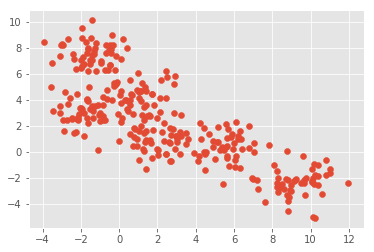

In [22]:
plt.scatter(pairs[:,0], pairs[:,1])

If you've followed along thus far, you should see three rough clusters to our data - or, if you've changed the value for "centers" in make_blobs, you'll see that many clusters. However, these really are rough. Where does one cluster end, and the next cluster start? K-Means is going to help us answer that by showing us what the midpoints - or, centroids - of this data are.

## Analyzing our data

Now we can get to work on our clustering. We're going to start off by randomly initializing our centroids (k-number of them). Let's write a function to implement this.

Our function will take in two arguments - a dataset, and k, the number of clusters in our data. Our function will then take our dataset and slice it. The way our function slices our dataset is by returning k-number of points, all selected randomly.

Putting that together, we now have k-number of randomly selected centroids.

In [23]:
def choose_centroids(dataset, k):
    return dataset[np.random.randint(0, len(dataset) - 1, size=k)] #randomly choose our initial centroids
    

choose_centroids(pairs, 3)

array([[ 8.87802623, -3.49059014],
       [ 5.57285532,  0.39565361],
       [ 2.50904929,  5.7731461 ]])

Sometimes you'll get lucky, and your centroids will already be pretty close to the midpoints they're trying to find - this is good! It means the algorithm won't have to repeat as many times. However, if your random centroids are all bunched up or are way off, then the algorithm will have to run more times.

So let's see what this looks like. Try the following cell a bunch of times, and see how close or far your centroids randomly initialize!

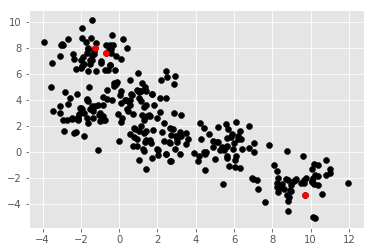

In [24]:
example_centroids = choose_centroids(pairs, 3)

plt.scatter(pairs[:,0], pairs[:,1], c='k')
plt.scatter(example_centroids[:,0], example_centroids[:,1], c='r')

Next, we need to define how close or far our centroids are from their goal. We'll do so using Euclidean distance. We can think about Euclidean distance very similarly to the Pythagorean theorem. 

In [25]:
def euclidean(a, b):
    return np.linalg.norm(a-b)

The goal of the Euclidean distance is to determine how far two points are from each other on a real number plane (like our plot). In our image below, we see how we can think about our two points - (x<sub>1</sub>,y<sub>1</sub>) and (x<sub>2</sub>, y<sub>2</sub>) - being connected by a triangle. The Euclidean distance is simply the hypotenuse of this triangle - the straight line between them!

So, all we're really calculating is something a lot like the Pythagorean theorem. Credit for this image to [Rosalind.info](rosalind.info).

![Euclidean Distance](http://rosalind.info/media/Euclidean_distance.png)

Okay, now we can finally get into the actual K-Means algorithm. Fair warning, it's long - don't be intimidated! Nothing we're doing here is too complicated to understand. Let's go through this step by step, in plain English. We'll create a function, kmeans, that takes a dataset, a k value, and a maximum number of iterations as its arguments.

```python
def kmeans(dataset, k, max_iterations):
```

1. We create a list to hold the history of how our centroids and clusters change, and variables to hold the number of rows and columns in our data.

```python
    old_centroids = []
    old_clusters_list = []
```

2. We use the function we wrote to randomly choose our first centroids. We then add them to our list as the very first point in our centroids' history.

```python
    current_centroids = choose_centroids 
    old_centroids.append(current_centroids)
```


   Now, we've set up the data structures we need for our algorithm, and we can begin our analysis. I recommend stopping every few steps, or wherever it feels natural, to look away from all the text and code and to simply think about what's happening in our code. <br/>

3. Our first for loop is simply the number of times our algorithm is going to run. 

    ```python
    for i in range(max_iterations):
    ```
4. Next we'll assign each data point to a centroid by finding the centroid closest to each point. We'll make this a separate function called assign_points and come back to it in a bit. Just know that this function will return a list of numbers (1, 2, or 3) signifying which cluster each data point is assigned to. We'll take this list and add it to our list of old clusters.

    ```python
    cluster_list = assign_points(dataset, current_centroids)
    old_clusters_list.append(cluster_list)
    ```

5. Now, we begin another loop. This time we're going to go through all of our centroids. We'll create a temporary variable to hold our new centroid locations so that no values are overwritten as we iterate through. 

    ```python
    temp_centroid = np.zeros((k, 2))
    
    for index in range(len(current_centroids)):
    ```
6. This step uses a neat trick called list comprehension. It's simply a shortcut to do what you could also do with a normally written for loop. Here, we'd normally create an empty list, then loop through and append each point. This is essentially doing the same thing. <br/> <br/> The goal of this step is to re-evaluate our centroids. The way we'll do that is by taking every point belonging to each cluster, and finding the average. So, we'll start off by using list comprehension to create a list of points in the current cluster. We do this by comparing our cluster_list index to the current centroid we're looking at.

    ```python
    temp_centroid = np.zeros((k, 2))
    
    for index in range(len(current_centroids)):
        points_in_cluster = [i for i in range(len(cluster_list)) if cluster_list[i] == index]
    ```
7. Almost done! We'll complete our loop by using numpy's mean function to create our newest centroid (which is no longer random, now the average of all the points in the cluster), and assigning it to our temp_centroid list that holds our new centroid locations.

    ```python
    temp_centroid = np.zeros((k, 2))
    
    for index in range(len(current_centroids)):
        points_in_cluster = [i for i in range(len(cluster_list)) if cluster_list[i] == index]
            
        centroid = np.mean(dataset[points_in_cluster], axis=0)
        temp_centroid[index, :] = centroid
    ```
8. We then set our most recent/current centroids to what we've just calculated, and add it to our history list.

    ```python
    current_centroids = temp_centroid
       
    old_centroids.append(temp_centroid)
    ```
    Then we'll want to reassign all the data points one more time and save that to our list again <br/><br/>
    ```python
    cluster_list = assign_points(dataset, current_centroids)   
    old_clusters_list.append(cluster_list)
    ```
9. Finally, we return our calculations! We want our function to provide the most up-to-date centroids, our history of the locations of all of our centroids previously, the list of clusters that each point has been assigned to, and the history of our clusters.

    ```python
    return current_centroids, old_centroids, cluster_list, old_clusters_list
    ```
    


10. Now as promised, we're going to see how we assign each data point to a centroid. Our function is going to be called assign_points and take a dataset and the current centroids. We'll also create an empty array __cluster_list__ with the same length as the dataset. This will hold the cluster (1, 2, or 3) that each data point has been assigned to.

    ```python
    def assign_points(dataset, centroids):
        cluster_list = np.zeros((dataset.shape[0], 1)) 
    ```

11. For every point in our data set, we're going to calculate the Euclidean distance between our point and our current centroids. Here, we set up an empty array to hold our distances.

    ```python
    for row, data_point in enumerate(dataset):
        distance_array = np.zeros((centroids.shape[0],1))
    ```

12. Now we're going to go through each of our centroids. So, for each point in our dataset, we're going to compare it with our k (three, here) centroids. We're then going to assign the distance between our point and each centroid to our distance array. <br/> <br/> We use enumerate to allow us to create two variables - row and data_point - as our loop counters. This is just to help us understand what we're doing.

    ```python
        for row, data_point in enumerate(dataset):
            distance_array = np.zeros((centroids.shape[0],1))
            
            for centroid_index, centroid in enumerate(centroids):
                distance_array[centroid_index] = euclidean(centroid, data_point)
    ```
13. np.argmin will take the smallest distance between our point and our centroids, and assign our point to that cluster (by storing it in cluster_list). In other words, we're finding the centroid that our point is closest to. 

    ```python
for row, data_point in enumerate(dataset):
        distance_array = np.zeros((centroids.shape[0],1))
        for centroid_index, centroid in enumerate(centroids):
            distance_array[centroid_index] = euclidean(centroid, data_point)
        cluster_list[row, 0] = np.argmin(distance_array)              
        
    ```
    
    If you haven't already, now's a good time to stop and ponder. Why are we finding the centroid our point is closest to? <br/> <br/>

14. That completes the loop of assigning data points to centroids. Now all we need to do is return cluster_list.

In [26]:
def assign_points(dataset, centroids):
    cluster_list = np.zeros((dataset.shape[0], 1)) #a null array to hold the assigned cluster of every point in the dataset
    for row, data_point in enumerate(dataset): #for each row/data point in the dataset
        distance_array = np.zeros((centroids.shape[0],1)) #a null array to hold the distances between the point and our three centroids

        for centroid_index, centroid in enumerate(centroids): #for each centroid
            distance_array[centroid_index] = euclidean(centroid, data_point) #compute the distance between the point and centroid

        cluster_list[row, 0] = np.argmin(distance_array) #find the smallest distance, assign that distance to a cluster
    return cluster_list
    

We did it! That's our implementation of K-Means clustering. Now, let's put it all together:

In [27]:

def kmeans(dataset, k, max_iterations):
    old_centroids = [] #list to store past centroids
    old_clusters_list = []# a null array to hold the hold old cluster lists (to show progress over time)
    
    current_centroids = choose_centroids(dataset, k) #randomly choose centroids
    old_centroids.append(current_centroids) #set these to our list of past centroid (to show progress over time)
    
    for i in range(max_iterations):        
        cluster_list = assign_points(dataset, current_centroids) #assign each point to a centroid
        old_clusters_list.append(cluster_list) #add our clusters to our history for plotting

        temp_centroid = np.zeros((k, 2)) #acts as a buffer while we compute new centroids
        
        for index in range(len(current_centroids)): #for each cluster (k of them)
            points_in_cluster = [i for i in range(len(cluster_list)) if cluster_list[i] == index] #get all the points assigned to a cluster
            centroid = np.mean(dataset[points_in_cluster], axis=0) #find the mean of those points, this is our new centroid
            temp_centroid[index, :] = centroid #add our new centroid to our new temporary list
        
        current_centroids = temp_centroid #set the new list to the current list
        
        old_centroids.append(temp_centroid) #add our calculated centroids to our history for plotting
    cluster_list = assign_points(dataset, current_centroids) #reassign the clusters one last time    
    old_clusters_list.append(cluster_list) #add the last cluster list to our list of old clusters
    
    return current_centroids, old_centroids, cluster_list, old_clusters_list
#Our function computes and returns our centroids with their histories, as well as data point's cluster

## Plotting the data

If you want to stop there, that's completely fine; that's K-Means! However, it's good practice to visualize what you're doing - both to catch errors, and to understand what you're really doing.

Let's define a function to plot our data. I won't go through this quite as in depth. We'll plot all of our clusters in different colors. Let's take a list of colors, and narrow it down to how many we'll need (by how many clusters we have). <br/>

We create our pyplot figure and axis. Now we have to plot our points, and then our centroids.

Let's go through every point in the data set. We use list comprehension to create a list of all points in each cluster, and then take each point and plot them with the color for that cluster. Then we loop through our centroids, and plot them as well.

In [28]:
def plot(dataset, old_centroids, cluster_list, k):
    list_of_colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'w'] #list of colors for each cluster
    #it is possible but extremely unlikely that you will have more clusters, and need more colors, than this

    colors = list_of_colors[:k] #take colors for as many clusters as we're using
    
    figure, axis = plt.subplots()

    for index in range(dataset.shape[0]): #for every point in the data set
        points_in_cluster = [i for i in range(len(cluster_list)) if cluster_list[i] == index] #Let's grab every point in the cluster
        for point_index in points_in_cluster: #for each point in cluster
            axis.plot(dataset[point_index,0], dataset[point_index,1], (colors[index] + 'o')) #plot the point with the cluster's color

    for centroid in old_centroids:
        axis.plot(centroid[0], centroid[1], 'ko', ms=10)
    plt.show()

Finally, let's tie together everything we've done. We'll make a run() method that first executes our K-Means algorithm. We then plot each stage of our algorithm (by using our old_centroids), and this is what we see: 

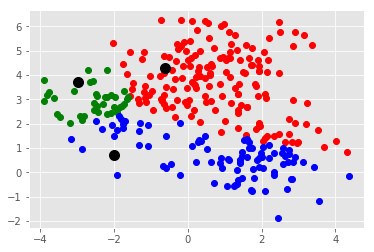

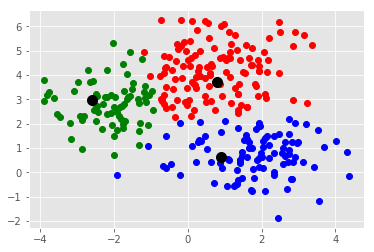

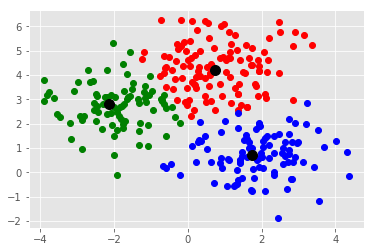

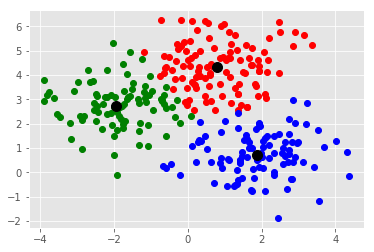

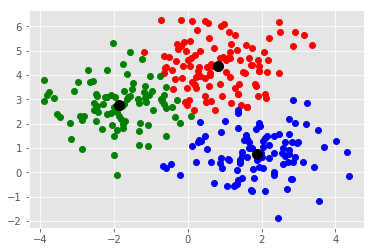

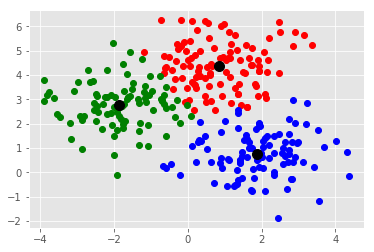

In [31]:
def run(data, k, max_iterations):
    current_centroids, old_centroids, cluster_list, old_clusters_list = kmeans(data, k, max_iterations)

    for index,item in enumerate(old_centroids): #this includes the last one
        plot(data, item, old_clusters_list[index], k)

run(pairs, 3, 5)

Watch how the centroids adjust. Depending on how lucky you get with your initialization, you may not even need as many as 5 iterations. Or, you may need more! <br/> <hr/>

## Conclusion

Congratulations; you've completed your first clustering algorithm! Remember, K-Means is used with unlabeled, continuous data, with several (or many) features.

There are lots of cool ways K-Means can be implemented with real world data - namely, for things like identifying disease, cybersecurity, search engines, consumer analysis, and many more. A super interesting application can be found [here](https://www.kaggle.com/drgilermo/3d-kmeans-animation/notebook). 

How can you apply K-Means to your data?

### Bonus

Notice that in our algorithm, we specified how many times we wanted our algorithm to run. It can be cumbersome to try running it 10 times, 20 times, 30, 31, 32... 

Can you think of a way to automatically tell our algorithm how many times it should run? <i>Hint: Another way to think about it is, "When should the algorithm <b>stop</b> running?"</i>

### SciKit-Learn

What you've learned in this workshop is how K-Means works from the ground up. However, after you gain a full understanding of the algorithm and how it works, there's no need to continually re-implement it over and over. The SciKit-Learn package has a [K-Means function](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) built-in, should you prefer to use a pre-built function. 

### Other Resources

* [Siraj Raval's video on K-Means clustering](https://www.youtube.com/watch?v=9991JlKnFmk&pbjreload=10)
* [Explaining K-Means](http://bigdata-madesimple.com/possibly-the-simplest-way-to-explai n-k-means-algorithm/)
* [Sk-Learn K-Means function on handwritten digits - demo](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html)